(model_evaluation)=

# Model Evaluation

How can we evaluate the predictive performance of our model and ensure we select the best one? In most machine learning courses, you will learn about predictive performance metrics that measure how well your model predicts. Different metrics are appropriate for different scenarios. In this chapter, we will cover the performance metrics displayed in {numref}`metrics`. However, keep in mind that in practice, there are typically many other desiderata beyond predictive performance, such as complexity, maintainability, and available resources.

## Predictive Performance Metrics

```{list-table} Overview of predictive performance metrics.
:header-rows: 1
:name: metrics

* - metric
  - formula
  - equivalent to
  - example implementation
* - accuracy
  - $\frac{tp + tn}{tp+tn+fp+fn}$
  -
  - {py:func}`sklearn.metrics.accuracy_score()`
* - false positive rate (fpr)
  - $\frac{fp}{fp+tn}$
  - $1 - tnr$
  - {py:func}`fairlearn.metrics.false_positive_rate()`
* - true negative rate (tnr)
  - $\frac{tn}{fp+tn}$
  - $1 - fpr$
  - {py:func}`fairlearn.metrics.true_negative_rate()`
* - false negative rate (fnr)
  - $\frac{fn}{fn+tp}$
  - $1 - tpr$
  - {py:func}`fairlearn.metrics.false_negative_rate()`
* - true positive rate (tpr)
  - $\frac{tp}{fn+tp}$
  - $1 - fnr$; recall
  - {py:func}`fairlearn.metrics.true_positive_rate()`
* - recall
  - $\frac{tp}{tp+fn}$
  - tpr
  - {py:func}`sklearn.metrics.recall_score()`
* - precision
  - $\frac{tp}{tp+fp}$
  -
  - {py:func}`sklearn.metrics.precision_score()`
* - F1-score
  - $\frac{tp}{tp + \frac{1}{2}(fp+tn)}$
  - $2 \cdot \frac{precision \cdot recall}{precision + recall}$
  - {py:func}`sklearn.metrics.f1_score()`
* - positive predictive value (ppv)
  - $\frac{tp}{tp+fp}$
  - precision
  - {py:func}`sklearn.metrics.precision_score()`
* - negative predictive value (npv)
  - $\frac{tn}{tn+fn}$
  -
  - N/A
```

(model_evaluation_classification_metrics)=

## Performance metrics based on the predicted class

The confusion matrix is a basic tool that indicates how well a classification model performs for different classes. One axis displays the true labels and the other axis the predicted labels. Each cell $C_{i,j}$ shows the number of instances in some class $i$ that were predicted to be class $j$. Despite its name, this matrix is not supposed to confuse you. It visualizes whether the classifier is confusing particular classes (i.e., misclassifying one as another). In a binary classification problem, the confusion matrix contains the number of true positives (tp), false positives (fp), true negatives (tn), and false negatives (fn).

```{list-table} The structure of a confusion matrix of a binary classification problem. In practice, the cells will contain the number of observations of each type.
:header-rows: 1
:name: confusionmatrix

* -
  -
  - predicted label
  -
* -
  -
  - *negative* (`0`)
  - *positive* (`1`)
* - **actual label**
  - *negative* (`0`)
  - true negative (tn)
  - false positive (fp)
* -
  - *positive* (`1`)
  - false negative (fn)
  - true positive (tp)
```

We first create a synthetic data set and build a logistic regression classifier on top of it. We will use these as a running example throughout this chapter.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# create synthethic data set
X, y = make_classification(random_state=1)

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# train classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# make predictions
y_pred = clf.predict(X_test)

```{note}
The [`random_state`](https://scikit-learn.org/stable/glossary.html#term-random_state) parameter in scikit-learn algorithms controls randomization. By setting it to an integer, we can ensure that we retrieve the same results across different calls.
```

```{note}
:class: seealso

You may have noticed that we first split the synthetic data into a train and test set using {py:func}`sklearn.model_selection.train_test_split`. Why this is an essential part of a proper machine learning pipeline will be explained in more detail in chapter [Model Selection](model_selection).
```

We can use {py:func}`sklearn.metrics.confusion_matrix` to easiliy compute the confusion matrix:

In [2]:
from sklearn.metrics import confusion_matrix

# y_pred are our model's predictions
display(confusion_matrix(y_test, y_pred))

array([[12,  1],
       [ 2, 10]])

Many popular predictive performance metrics for binary classification problems can be directly derived from the confusion matrix.

### Accuracy

Accuracy is one of the simplest measures of predictive performance. It can be defined as the fraction of predictions the model predicted correctly (see {numref}`metrics`).

Note that accuracy does not differentiate between mistakes made for one class versus mistakes made for another class. As a result, **accuracy can be a misleading metric when we are dealing with imbalanced data**, which occurs when the number of instances per class differs greatly across classes.

For example, consider fraud detection in bank transactions. The number of legal transactions typically greatly outnumbers the number of illegal transactions. Let's say that for every 99999 transactions, there is 1 illegal transaction. In this scenario, a model that predicts every transaction to be legitimate will receive an incredibly high accuracy score: 0.99999. Of course, the practical utility of this model is very low.

In [3]:
from sklearn.metrics import accuracy_score

# compute accuracy score of the classifier for the test data
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print('accuracy: {:.2f}'.format(acc))

accuracy: 0.88


### Misclassification rates

In many use cases, false positives and false negatives have different consequences in the real world. As a running example, we take the fraud detection scenario.

The false positive rate ($fpr$) is equal to the fraction of false positives out of all negative instances. In the fraud detection scenario, this corresponds to the fraction of false alerts out of all legitimate transactions. To avoid flooding fraud analysts with false alerts, we may want to keep the $fpr$ below a certain level. The true negative rate ($tnr$) is equal to the fraction of true negatives out of all negative instances, which is equivalent to $1-fpr$.

The true positive rate ($tpr$) is equal to the fraction of true positives out of all positive instances. In the fraud detection scenario, this metric quantifies the fraction of fraudulent transactions we were able to identify as such. The false negative rate ($fnr$) is equal to the fraction of false negatives out of all positive instances. This corresponds to the fraction of fraudulent transactions we failed to identify out of all fraudulent transactions. The false negative rate is equal to $1 - tpr$.

In [4]:
from fairlearn.metrics import (false_positive_rate, true_negative_rate,
                               true_positive_rate, false_negative_rate)

# compute misclassification rates of the classifier for the test data
fpr = false_positive_rate(y_true=y_test, y_pred=y_pred)
tnr = true_negative_rate(y_true=y_test, y_pred=y_pred)
fnr = false_negative_rate(y_true=y_test, y_pred=y_pred)
tpr = true_positive_rate(y_true=y_test, y_pred=y_pred)

print("""
fpr: {:.2f}
tnr: {:.2f}
fnr: {:.2f}
tpr: {:.2f}
""".format(fpr, tnr, fnr, tpr))


fpr: 0.08
tnr: 0.92
fnr: 0.17
tpr: 0.83



Compared to the accuracy score we computed earlier, misclassification rates give us more insight into which classes the model classified (in)correctly. In this case, the classifier is better at distinguishing instances that belong to the negative class compared to the positive class ($tnr > tpr$ or conversely $fpr < fnr$).

### Precision, Recall, and F1-score

Precision, recall, and the F1-score were originally introduced in the context of information retrieval, a domain concerned with retrieving information (text, audio, images, data, etc.) based on a query. An example of an information retrieval system is a search engine. Developers of information retrieval systems are often concerned with the _relevance_ of the retrieved results, which can be quantified using precision and recall.

Precision is defined as the fraction of retrieved documents that were actually relevant (i.e., how precise is the retrieved result?). In a general classification problem, the metric is defined as the fraction of positive instances among the predicted positive instances. Recall, on the other hand, is defined as the fraction of all relevant documents that were successfully retrieved (i.e., how many of the relevant documents are recalled?). In a classification setting, recall refers to the number of positive instances the model classified as such from all positive instances in the data set, which is equivalent to the true positive rate.

Often, there is an inverse relationship between precision and recall, which is referred to as the precision-recall trade-off. In practice, we might find both precision and recall important. This is where the f1-score comes in, which is defined as the harmonic mean of precision and recall. The f1-score is just one way to aggregate precision and recall. Importantly, this makes the score only relevant in scenarios where we believe precision and recall are equally important. There also exists a more general $F_{\beta}$-score, where $\beta$ is chosen such that recall is considered $\beta$ times as important as precision.

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score

# compute misclassification rates of the classifier for the test data
precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)

print("""
precision: {:.2f}
recall:    {:.2f}
f1 score:  {:.2f}
""".format(precision, recall, f1))


precision: 0.91
recall:    0.83
f1 score:  0.87



### Positive Predictive Value and Negative Predictive Value

If an instance is predicted to be of a certain class, the positive predictive value and negative predictive value describe how likely it is the classification is correct. For example, if we predict a patient has a disease, the positive predictive value gives us the probability that the patient actually has the disease. The positive predictive value is equivalent to precision. We can interpret the negative predictive value as the 'precision' for the negative class.

In [6]:
def npv_score(y_true, y_pred, **kwargs):
    """
    NPV is not implemented in scikit-learn, but is the same as PPV (i.e., precision)
    for the negative class.
    """
    return precision_score(y_true, y_pred, pos_label=0, **kwargs)

# compute misclassification rates of the classifier for the test data
ppv = precision_score(y_true=y_test, y_pred=y_pred)
npv = npv_score(y_true=y_test, y_pred=y_pred)

print("""
ppv: {:.2f}
npv: {:.2f}
""".format(ppv, npv))


ppv: 0.91
npv: 0.86



(performancemetricsscore)=

## Performance metrics based on the predicted scores

The evaluation metrics discussed so far are only defined for predicted classes. However, many machine learning algorithms do not directly output a class, but a confidence score which indicates the confidence of the model that an instance belongs to a certain class.

In [7]:
import matplotlib.pyplot as plt

# retrieve predicted classes
y_pred = clf.predict(X_test)
print('predicted classes: {}'.format(y_pred))

# print confidence scores instead of discrete predictions
print('confidence scores: {}'.format(clf.predict_proba(X_test)))

# retrieve confidence scores for the positive class
y_score = clf.predict_proba(X_test)[:, 1]
print('confidence scores positive class: {}'.format(y_score))

predicted classes: [0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1]
confidence scores: [[0.95318273 0.04681727]
 [0.99617159 0.00382841]
 [0.02117635 0.97882365]
 [0.97583057 0.02416943]
 [0.0332806  0.9667194 ]
 [0.02815556 0.97184444]
 [0.30326393 0.69673607]
 [0.66935727 0.33064273]
 [0.91678782 0.08321218]
 [0.03950548 0.96049452]
 [0.92708598 0.07291402]
 [0.99829629 0.00170371]
 [0.70518227 0.29481773]
 [0.63641324 0.36358676]
 [0.2251617  0.7748383 ]
 [0.18185178 0.81814822]
 [0.97925552 0.02074448]
 [0.06003966 0.93996034]
 [0.25534451 0.74465549]
 [0.9880332  0.0119668 ]
 [0.01421573 0.98578427]
 [0.87356955 0.12643045]
 [0.96832768 0.03167232]
 [0.99022228 0.00977772]
 [0.03662168 0.96337832]]
confidence scores positive class: [0.04681727 0.00382841 0.97882365 0.02416943 0.9667194  0.97184444
 0.69673607 0.33064273 0.08321218 0.96049452 0.07291402 0.00170371
 0.29481773 0.36358676 0.7748383  0.81814822 0.02074448 0.93996034
 0.74465549 0.0119668  0.98578427 0.12643045 0.03

```{note}
:class: tip

In scikit-learn, `predict_proba()` returns an array of shape `(n_samples, n_classes)`. To get the confidence scores for the positive class, we need to select the part of the `numpy.ndarray` that corresponds to the positive predictions. In the binary classification scenario with class $0$ and $1$, this corresponds to the second value for each sample, i.e., `[:, 1]]`.
```

Based on the confidence score, we can decide how to classify an instance. In a binary classification scenario, this is typically done using a decision threshold: the cut-off value of the model's confidence score at which an instance is classified as positive. The choice of decision threshold can be an important tool to control the trade-off between false positives and false negatives (see also {ref}`cost_sensitive_learning`).

(roc_curve)=

### ROC curve

A popular tool for investigating the trade-off between false positives and false negatives is the Receiver Operating Characteristic curve (ROC curve`). **The ROC curve plots the true positive rate against the false positive rate. Each point on the curve corresponds to a different decision threshold.**

We can compute the false positive rate and true positive rates at different thresholds using {py:func}`sklearn.metrics.roc_curve`, but to save ourselves some lines of code we use the plotting functionality of {py:class}`sklearn.metrics.RocCurveDisplay`.

ROC-AUC: 0.94


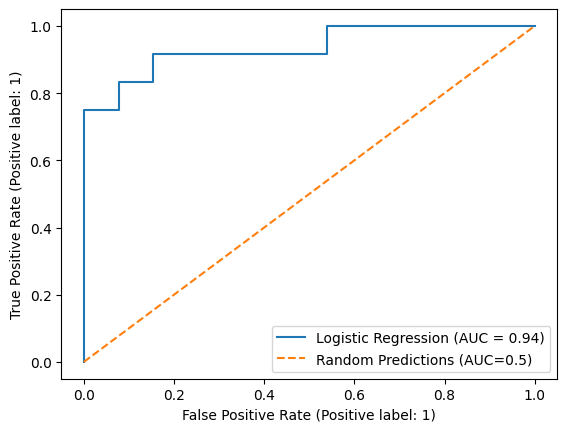

In [8]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# compute area under the ROC curve
roc_auc = roc_auc_score(y_true=y_test, y_score=y_score)
print('ROC-AUC: {:.2f}'.format(roc_auc))

# plot ROC curve from predictions
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=y_score, name='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle="--", label='Random Predictions (AUC=0.5)')
plt.legend()
plt.show()

To quantify the aggregate classification performance of the machine learning model, the ROC curve can be summarized as the Area Under the ROC curve (AUC). For a binary classification problem, an AUC of 0.5 is equal to a classifier that makes random predictions. An AUC of 1 corresponds to perfect separation between the positive and negative classes.

AUC can be useful to compare the aggregate predictive performance of different models during model selection. However, **AUC summarizes the performance of the model across all possible decision thresholds. To actually use the model for classifying instances, you still need to choose a decision threshold.** As such, unlike confusion-based metrics, AUC typically does not directly correspond to real-world constraints or objectives. For example, in fraud detection, we may want to limit the expected number of false positives such that it is still humanly possible for fraud analysts to process all fraud alerts. Similarly, there may be different costs associated with false positives and false negatives making specific subspaces of the ROC curve more attractive than others.

(precision_recall_curve)=

### Precision-Recall Curve

In some problems, it may be valuable to evaluate the precision-recall trade-off across varying decision thresholds. Lowering the decision threshold effectively means that instances the model was not as confident about will be classified as positive. This can increase recall but may come at the cost of precision, as more negative (i.e., irrelevant) instances are classified as positive as well. Similar to the ROC curve, a precision-recall curve can be used to decide on the right threshold for your use case. The precision-recall curve can be summarized using average precision, which is the average precision score computed over all recall values.

average precision: 0.95


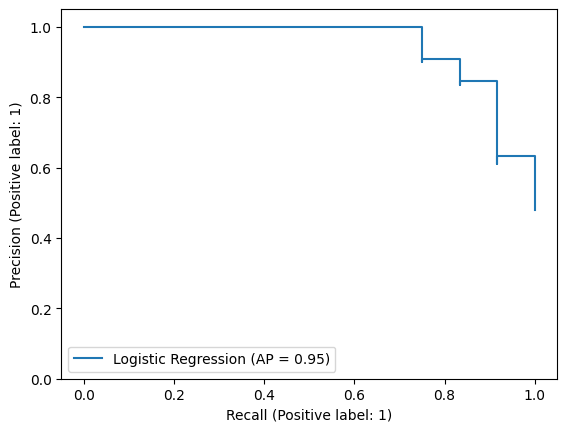

In [9]:
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay

# compute average precision
avg_precision = average_precision_score(y_true=y_test, y_score=y_score)
print('average precision: {:.2f}'.format(avg_precision))

# plot precision-recall curve
PrecisionRecallDisplay.from_predictions(y_true=y_test, y_pred=y_score, name='Logistic Regression')
plt.ylim(0,1.05)
plt.show()

(model_calibration)=

## Model Calibration

The confidence score is sometimes referred to as the predicted probability. However, **the predicted values of many machine learning algorithms cannot be directly interpreted as probabilities**. Calibration is the extent to which the predicted value corresponds to an actual probability. For example, a model is well-calibrated if out of all instances that receive a confidence score of 0.7, the fraction of instances that belong to the positive class is also 0.7. Calibration can be an important characteristic when confidence scores are used for decision-making by domain experts. In particular, a decision threshold for calibrated scores can be directly interpreted in terms of different misclassification costs. For example, if a calibrated confidence score is used for suggesting a specific treatment in clinical decision-making, a decision threshold of 0.1 means that we accept up to 9 false positives (i.e., unnecessary treatments) for each true positive. Such a direct connection between misclassification rates and a particular decision threshold cannot be made for uncalibrated scores - although we can still, of course, compute precision to draw similar conclusions.

You can assess how well a model is calibrated using a calibration curve, which sets out the mean predicted probability against the fraction of positives.

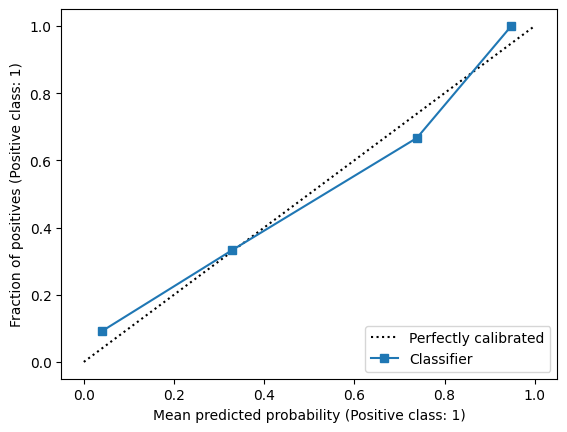

In [10]:
from sklearn.calibration import CalibrationDisplay

# plot calibration curve
disp = CalibrationDisplay.from_predictions(y_true=y_test, y_prob=y_score)
plt.show()

We can also plot the calibration 'curve' for classifications. This curve contains only two points: one for the positive class and one for the negative class.

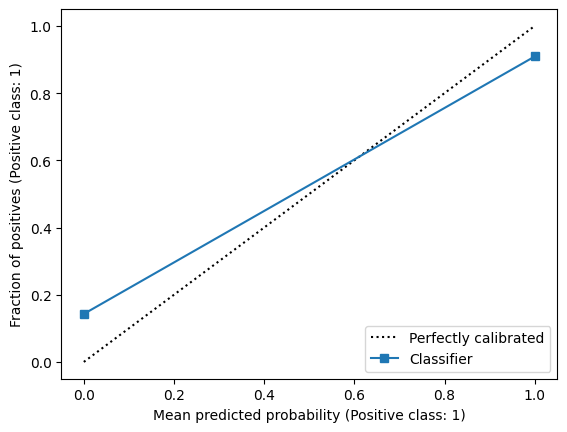

In [11]:
# plot calibration curve for classifications
disp = CalibrationDisplay.from_predictions(y_true=y_test, y_prob=y_pred)
plt.show()

The calibration 'curve' of discrete predictions is closely related to the positive and negative predictive value. The fraction of positives with an average predicted value of `1` corresponds to the number of true positives out of all predicted positives, which is exactly the definition of the positive predictive value. The fraction of positives for the mean predicted value of `0` is equal to the fraction of false negatives out of all predicted negatives, which is exactly $1-npv$. As such, we can summarize the calibration of binary predictions using the predictive values.

There exist techniques to post-process confidence scores such that they are better calibrated. A discussion of these techniques is outside of the scope of this book. We refer interested readers to the [user guide of scikit-learn](https://scikit-learn.org/stable/modules/calibration.html#calibrating-a-classifier), which provides a useful introduction to the topic.